<a href="https://colab.research.google.com/github/Felipanjos/a3_ia_2022.2/blob/main/Projeto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [325]:
import pandas as pd
import numpy as np
import random
import string
import sklearn
from itertools import groupby

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [326]:
df = pd.read_csv('chip_dataset.csv', index_col=[0])
df.drop('FP16 GFLOPS', axis=1, inplace=True)
df.drop('FP32 GFLOPS', axis=1, inplace=True)
df.drop('FP64 GFLOPS', axis=1, inplace=True)
vendors = list(np.unique(df['Vendor']))

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4854 entries, 0 to 4853
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Product                4854 non-null   object 
 1   Type                   4854 non-null   object 
 2   Release Date           4854 non-null   object 
 3   Process Size (nm)      4845 non-null   float64
 4   TDP (W)                4228 non-null   float64
 5   Die Size (mm^2)        4139 non-null   float64
 6   Transistors (million)  4143 non-null   float64
 7   Freq (MHz)             4854 non-null   float64
 8   Foundry                4854 non-null   object 
 9   Vendor                 4854 non-null   object 
dtypes: float64(5), object(5)
memory usage: 417.1+ KB


In [328]:
num_attribs = list(df.describe().columns)
cat_attribs = ['Vendor']

### B. Divisão 

In [345]:
df.describe()

,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
count,4845.000000,4228.000000,4014.000000,4143.000000,4854.000000
mean,55.109598,81.359981,199.945192,1929.922279,1484.406057
std,44.998676,76.807808,147.199301,4044.891098,1066.701523
min,0.000000,1.000000,1.000000,8.000000,100.000000
25%,22.000000,33.000000,104.000000,154.000000,590.000000
50%,40.000000,65.000000,150.000000,624.000000,1073.500000
75%,90.000000,100.000000,246.000000,1550.000000,2400.000000
max,250.000000,900.000000,990.000000,54200.000000,4700.000000


<AxesSubplot: >

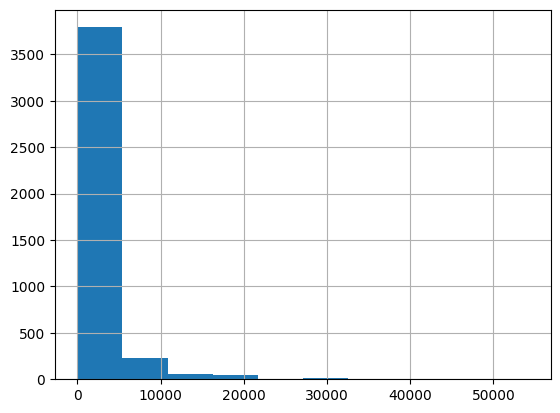

In [346]:
# matplotlib
df['Transistors (million)'].hist()

In [329]:
ranges = [df.min()['total'], df['total'].describe()['25%'], 4500, 9000, 10000, 25000, 100000, 200000, np.inf]
tiers = ['F', 'E', 'D', 'C', 'B', 'A', 'S', 'S+']

df['nome_col_cat'] = pd.cut(df['total'], bins = ranges, labels = tiers)

In [330]:
# df_num = pd.DataFrame(df_num, index=df.index, columns=df.columns)

In [331]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df, df['total_cat']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [332]:
strat_train_set.drop(columns=['income_cat'], inplace=True)
strat_test_set.drop(columns=['income_cat'], inplace=True)

In [333]:
strat_test_set['total_cat'].value_counts()

### C. Exploração 

### D. Preparação

##### a) Selecionando 10% das colunas

No dataset utilizado existem somente 9 colunas, dessa forma:

*    10% de 9 = 0.9
*    Aproximando para 1, fica somente uma coluna a ser selecionada como referência para a modificação dos dados



In [334]:
qtd_colunas = len(df.columns)
p_colunas = round(qtd_colunas * 10 / 100)
coluna_aleatoria = df.sample(n=p_colunas, axis='columns').keys()[0]
colunas_numericas = df.describe().columns
colunas_categoricas = df.describe(exclude=np.number).columns
coluna_aleatoria # escolhendo uma coluna aleatoriamente

'Die Size (mm^2)'

##### a) Selecionando 3% dos dados

In [335]:
p_3 = int(df.shape[0] * 3 / 100)
p_3 # 3% de 1000 é igual a 30

145

##### a) Excluindo 3% dos dados aleatoriamente

In [336]:
reg_nulos = df[df[coluna_aleatoria].isnull()]
qtd_reg_nulos = reg_nulos.shape[0]
reg_excluidos = df.sample(n=p_3)
reg_exc_index = reg_excluidos.index.array
df.loc[reg_exc_index, coluna_aleatoria] = np.nan

##### a) Alterando 3% dos dados aleatoriamente

In [337]:
def gerar_string_aleatoria():
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters) for i in range(10)) 

def gerar_numero_aleatorio():
  return random.randint(0, 999)

In [338]:
df_selecao_nao_nulo = df[~df[coluna_aleatoria].isnull()]
reg_alterados = df_selecao_nao_nulo.sample(n=p_3)
reg_alter_index = reg_alterados.index.array

In [339]:
if coluna_aleatoria in colunas_numericas:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_numero_aleatorio()
else:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_string_aleatoria()

#### b) Limpeza dos dados

i. Codificação One-Hot

In [340]:
encoder = OneHotEncoder()
onehot_encoded_df = pd.DataFrame(encoder.fit_transform(df[['Vendor']]).toarray())
onehot_encoded_df.columns = vendors

onehot_encoded_df = df.join(onehot_encoded_df)
onehot_encoded_df.drop('Vendor', axis=1, inplace=True)
onehot_encoded_df

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,AMD,ATI,Intel,NVIDIA,Other
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,1.0,0.0,0.0,0.0,0.0
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,1.0,0.0,0.0,0.0,0.0
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,0.0,0.0,1.0,0.0,0.0
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,0.0,0.0,1.0,0.0,0.0
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,NVIDIA Quadro 3000M,GPU,2011-02-22,40.0,75.0,332.0,1950.0,450.0,TSMC,0.0,0.0,0.0,1.0,0.0
4850,Intel GMA 950,GPU,2005-06-01,90.0,7.0,NaN,NaN,250.0,Intel,0.0,0.0,1.0,0.0,0.0
4851,NVIDIA GeForce GT 320M,GPU,2010-03-03,40.0,23.0,100.0,486.0,500.0,TSMC,0.0,0.0,0.0,1.0,0.0
4852,NVIDIA GeForce FX 5200,GPU,2003-03-06,150.0,NaN,65.0,29.0,250.0,TSMC,0.0,0.0,0.0,1.0,0.0


ii. Estratégia para dados numéricos ausentes - média

A atribuição da mediana geral foi utilizada para lidar com os valores nulos das colunas em que existiam, pelos seguintes motivos:

*   Número pequeno de colunas, logo a remoção completa de cada coluna em que houvesse valor nulo acarretaria na perda desnecessária de informações
*   Facilidade na implementação em comparação com o treinamento de predição e atribuição
*   Coesão com o dataset, visto que logo no primeiro quartil a coluna 'Meta_score' apresenta valor próximo à média


iii. Escalonamento de características: Padronização

iv. Pipeline transformadora

In [341]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),        
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs),
    ])

In [342]:
df_prepared = full_pipeline.fit_transform(df)